## Engineering a Data Pipeline for Topic Modeling the New York Times Archive

by Jenica Andersen

In [1]:
#Necessary imports! (Is any of this REALLY necessary??)
import pandas as pd
import numpy as np
#np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import re
#import string

#import nltk
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer
#from nltk.chunk import ne_chunk
#from nltk.tag import pos_tag

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Bring on the NYT archive data! These data are from Jan 2020 to Aug 1(?)

df = pd.read_csv(r'nyt_data_trim.csv')
text = df.snippet
print(text)

0         The gunman who shot two parishioners at the We...
1         Congress could do much more to protect America...
2         The tobacco and vaping industries and conserva...
3         Christina Iverson and Jeff Chen ring in the Ne...
4         Corrections that appeared in print on Wednesda...
                                ...                        
143254    The bill involves at least $260 billion in spe...
143255    The Biden administration will increase assista...
143256    Twitter has sent out requests for information ...
143257    These shows explore the origin of Vladimir Put...
143258    The United States announced that a C.I.A. dron...
Name: snippet, Length: 143259, dtype: object


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143259 entries, 0 to 143258
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    143259 non-null  int64 
 1   abstract      142595 non-null  object
 2   snippet       137968 non-null  object
 3   headline      143259 non-null  object
 4   pub_date      143259 non-null  object
 5   section_name  142381 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.6+ MB


In [4]:
df.headline

0         {'main': '‘Battling a Demon’: Drifter Sought H...
1         {'main': 'Protect Veterans From Fraud', 'kicke...
2         {'main': 'F.D.A. Plans to Ban Most E-Cigarette...
3         {'main': '‘It’s Green and Slimy’', 'kicker': '...
4         {'main': 'Corrections: Jan. 1, 2020', 'kicker'...
                                ...                        
143254    {'main': 'Doing the Math on the Inflation Redu...
143255    {'main': 'White House Retrofits Infrastructure...
143256    {'main': 'Twitter’s subpoenas of Musk’s banks ...
143257    {'main': '6 Podcasts About Political Scandals ...
143258    {'main': 'The Killing of Ayman al-Zawahri: Wha...
Name: headline, Length: 143259, dtype: object

In [5]:
df["headline"]= df["headline"].str.replace("{'main': '","")
df["headline"]= df["headline"].str.replace("'kicker': None,","")
df["headline"]= df["headline"].str.replace("'kicker': ","")
df["headline"]= df["headline"].str.replace("'content_kicker': None, ","")
df["headline"]= df["headline"].str.replace("'content_kicker': ","")
df["headline"]

/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_11349/1732100951.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["headline"]= df["headline"].str.replace("{'main': '","")


0         ‘Battling a Demon’: Drifter Sought Help Before...
1         Protect Veterans From Fraud',  'print_headline...
2         F.D.A. Plans to Ban Most E-Cigarette Flavors b...
3         ‘It’s Green and Slimy’', 'wordplay, the crossw...
4         Corrections: Jan. 1, 2020',  'print_headline':...
                                ...                        
143254    Doing the Math on the Inflation Reduction Act'...
143255    White House Retrofits Infrastructure Bill to B...
143256    Twitter’s subpoenas of Musk’s banks offer clue...
143257    6 Podcasts About Political Scandals and Upheav...
143258    The Killing of Ayman al-Zawahri: What We Know'...
Name: headline, Length: 143259, dtype: object

In [6]:
df_snip = df
df_snip.dropna(inplace=True)
df_snip = df_snip[["snippet", 'section_name', 'pub_date']]
df_snip['pub_date'] = pd.to_datetime(df_snip['pub_date']).dt.date
#dataframe[‘Date’] = pd.to_datetime(dataframe[‘DateTime’]).dt.date
df_snip.head()

/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_11349/1498403310.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snip['pub_date'] = pd.to_datetime(df_snip['pub_date']).dt.date


,snippet,section_name,pub_date
0,The gunman who shot two parishioners at the We...,U.S.,2020-01-01
1,Congress could do much more to protect America...,Opinion,2020-01-01
2,The tobacco and vaping industries and conserva...,Health,2020-01-01
3,Christina Iverson and Jeff Chen ring in the Ne...,Crosswords & Games,2020-01-01
4,Corrections that appeared in print on Wednesda...,Corrections,2020-01-01


In [7]:
#Use regex to remove the special characters from the text column, creating a new column call "preprocessed"
df_snip['preprocessed'] = df_snip.snippet.apply(lambda x: (re.sub(r"[^a-zA-Z0-9 ]", " ", x)))
#and remove the numbers from the preprocessed column
df_snip['preprocessed'] = df_snip.preprocessed.apply(lambda x: (re.sub(r'[0-9]', ' ', x)))
df_snip['preprocessed'] = df_snip['preprocessed'].str.lower()
df_snip.head()

/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_11349/2769197468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snip['preprocessed'] = df_snip.snippet.apply(lambda x: (re.sub(r"[^a-zA-Z0-9 ]", " ", x)))
/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_11349/2769197468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snip['preprocessed'] = df_snip.preprocessed.apply(lambda x: (re.sub(r'[0-9]', ' ', x)))
/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_11349/276919

,snippet,section_name,pub_date,preprocessed
0,The gunman who shot two parishioners at the We...,U.S.,2020-01-01,the gunman who shot two parishioners at the we...
1,Congress could do much more to protect America...,Opinion,2020-01-01,congress could do much more to protect america...
2,The tobacco and vaping industries and conserva...,Health,2020-01-01,the tobacco and vaping industries and conserva...
3,Christina Iverson and Jeff Chen ring in the Ne...,Crosswords & Games,2020-01-01,christina iverson and jeff chen ring in the ne...
4,Corrections that appeared in print on Wednesda...,Corrections,2020-01-01,corrections that appeared in print on wednesda...


In [8]:
#now begin to remove stopwords. Some words appear in the results but do not contribute significantly to interpretations. 
#Make custom list of words to remove, in addition to the common, English stop words.
my_additional_stop_words = ['said', 'say', 'new york times', 'u'
                           ]

stop_words = stopwords.words('english')
stop_words2 = list(stop_words)

for word in my_additional_stop_words:
    stop_words2.append(word)

#now create a column with stop words removed    
df_snip['filtered'] = df_snip.preprocessed.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words2)]))
df_snip.head()

/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_11349/322158150.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snip['filtered'] = df_snip.preprocessed.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words2)]))


,snippet,section_name,pub_date,preprocessed,filtered
0,The gunman who shot two parishioners at the We...,U.S.,2020-01-01,the gunman who shot two parishioners at the we...,gunman shot two parishioners west freeway chur...
1,Congress could do much more to protect America...,Opinion,2020-01-01,congress could do much more to protect america...,congress could much protect americans served c...
2,The tobacco and vaping industries and conserva...,Health,2020-01-01,the tobacco and vaping industries and conserva...,tobacco vaping industries conservative allies ...
3,Christina Iverson and Jeff Chen ring in the Ne...,Crosswords & Games,2020-01-01,christina iverson and jeff chen ring in the ne...,christina iverson jeff chen ring new year
4,Corrections that appeared in print on Wednesda...,Corrections,2020-01-01,corrections that appeared in print on wednesda...,corrections appeared print wednesday jan


In [9]:
sec = [
 'Arts',
 'At Home',
 'Books',
 'Briefing',
 'Business Day',
 'Climate',
 'Corrections',
 'Crosswords & Games',
 'Fashion & Style',
 'Food',
 'Health',
 'Magazine',
 'Movies',
 'New York',
 'Opinion',
 'Parenting',
 'Podcasts',
 'Real Estate',
 'Science',
 'Sports',
 'Style',
 'T Magazine',
 'Technology',
 'The Learning Network',
 'Theater',
 'Today’s Paper',
 'Travel',
 'U.S.',
 'Well',
 'World',
]

In [10]:
df_snip_filtered = df_snip[["filtered", "pub_date", "section_name"]]
df_snip_filtered = df_snip_filtered[(df_snip_filtered['section_name'].isin(sec))]
df_snip_filtered.to_csv("df_snip_filtered.csv", index = False, date_format = "date" )

In [11]:
df_snip_filtered.section_name.unique()

array(['U.S.', 'Opinion', 'Health', 'Crosswords & Games', 'Corrections',
       'Today’s Paper', 'World', 'Science', 'Arts', 'Business Day',
       'Magazine', 'Books', 'Well', 'Travel', 'Technology', 'New York',
       'Movies', 'Real Estate', 'Sports', 'Theater', 'Food', 'Style',
       'Parenting', 'Briefing', 'Climate', 'The Learning Network',
       'Podcasts', 'T Magazine', 'Fashion & Style', 'At Home'],
      dtype=object)

In [12]:
#create a list of the preprocessed and filtered documents for further topic modeling
corpus = list(df_snip.filtered)
type(corpus)
len(corpus)

137094

In [13]:
#name the stemmers. We will explore all three. 
#After exploring all three, the Porter stemmer was used in the results. The Lancaster and Snowball stemmer dtms are further below.
porter = PorterStemmer()
snowball = SnowballStemmer(language = 'english')
lancaster = LancasterStemmer()

In [14]:
#create a column 
df_snip['tokenized'] = df_snip.filtered.apply(lambda x: RegexpTokenizer("\s+", gaps=True).tokenize(x))#' '.join([word for word in x.split() if word not in (stop_words2)]).porter.stem(x))
df_snip['snowball'] = df_snip['tokenized'].apply(lambda x: [snowball.stem(y) for y in x]) # Stem every word.
df_snip.head()

,snippet,section_name,pub_date,preprocessed,filtered,tokenized,snowball
0,The gunman who shot two parishioners at the We...,U.S.,2020-01-01,the gunman who shot two parishioners at the we...,gunman shot two parishioners west freeway chur...,"[gunman, shot, two, parishioners, west, freewa...","[gunman, shot, two, parishion, west, freeway, ..."
1,Congress could do much more to protect America...,Opinion,2020-01-01,congress could do much more to protect america...,congress could much protect americans served c...,"[congress, could, much, protect, americans, se...","[congress, could, much, protect, american, ser..."
2,The tobacco and vaping industries and conserva...,Health,2020-01-01,the tobacco and vaping industries and conserva...,tobacco vaping industries conservative allies ...,"[tobacco, vaping, industries, conservative, al...","[tobacco, vape, industri, conserv, alli, inten..."
3,Christina Iverson and Jeff Chen ring in the Ne...,Crosswords & Games,2020-01-01,christina iverson and jeff chen ring in the ne...,christina iverson jeff chen ring new year,"[christina, iverson, jeff, chen, ring, new, year]","[christina, iverson, jeff, chen, ring, new, year]"
4,Corrections that appeared in print on Wednesda...,Corrections,2020-01-01,corrections that appeared in print on wednesda...,corrections appeared print wednesday jan,"[corrections, appeared, print, wednesday, jan]","[correct, appear, print, wednesday, jan]"


In [15]:
#RUN THIS ONLY ONE TIME to unnest the list in each doc--running it more than once will tokenize the individual letters
df_snip['snowball'] = df_snip['snowball'].apply(lambda x: ' '.join([word for word in x]))
df_snip

,snippet,section_name,pub_date,preprocessed,filtered,tokenized,snowball
0,The gunman who shot two parishioners at the We...,U.S.,2020-01-01,the gunman who shot two parishioners at the we...,gunman shot two parishioners west freeway chur...,"[gunman, shot, two, parishioners, west, freewa...",gunman shot two parishion west freeway church ...
1,Congress could do much more to protect America...,Opinion,2020-01-01,congress could do much more to protect america...,congress could much protect americans served c...,"[congress, could, much, protect, americans, se...",congress could much protect american serv coun...
2,The tobacco and vaping industries and conserva...,Health,2020-01-01,the tobacco and vaping industries and conserva...,tobacco vaping industries conservative allies ...,"[tobacco, vaping, industries, conservative, al...",tobacco vape industri conserv alli intens lobb...
3,Christina Iverson and Jeff Chen ring in the Ne...,Crosswords & Games,2020-01-01,christina iverson and jeff chen ring in the ne...,christina iverson jeff chen ring new year,"[christina, iverson, jeff, chen, ring, new, year]",christina iverson jeff chen ring new year
4,Corrections that appeared in print on Wednesda...,Corrections,2020-01-01,corrections that appeared in print on wednesda...,corrections appeared print wednesday jan,"[corrections, appeared, print, wednesday, jan]",correct appear print wednesday jan
...,...,...,...,...,...,...,...
143254,The bill involves at least $260 billion in spe...,Business Day,2022-08-02,the bill involves at least billion in spe...,bill involves least billion spending years foc...,"[bill, involves, least, billion, spending, yea...",bill involv least billion spend year focus ene...
143255,The Biden administration will increase assista...,U.S.,2022-08-02,the biden administration will increase assista...,biden administration increase assistance areas...,"[biden, administration, increase, assistance, ...",biden administr increas assist area lack capac...
143256,Twitter has sent out requests for information ...,Business Day,2022-08-02,twitter has sent out requests for information ...,twitter sent requests information banks backin...,"[twitter, sent, requests, information, banks, ...",twitter sent request inform bank back billiona...
143257,These shows explore the origin of Vladimir Put...,Arts,2022-08-02,these shows explore the origin of vladimir put...,shows explore origin vladimir putin two decade...,"[shows, explore, origin, vladimir, putin, two,...",show explor origin vladimir putin two decad re...


In [16]:
sorted(df_snip.section_name.unique())

['Admin',
 'Arts',
 'At Home',
 'Automobiles',
 'Books',
 'Briefing',
 'Burst',
 'Business Day',
 'Climate',
 'Corrections',
 'Crosswords & Games',
 'Education',
 'Fashion & Style',
 'Food',
 'Guide',
 'Guides',
 'Headway',
 'Health',
 'Home & Garden',
 'Homepage',
 'International Home',
 'Job Market',
 'Magazine',
 'Movies',
 'Multimedia/Photos',
 'Neediest Cases',
 'New York',
 'Obituaries',
 'Opinion',
 'Parenting',
 'Podcasts',
 'Reader Center',
 'Real Estate',
 'Science',
 'Slideshows',
 'Smarter Living',
 'Special Series',
 'Sports',
 'Style',
 'Sunday Review',
 'T Brand',
 'T Magazine',
 'Technology',
 'The Learning Network',
 'The New York Times Presents',
 'The Upshot',
 'The Weekly',
 'Theater',
 'Times Insider',
 'Today’s Paper',
 'Topics',
 'Travel',
 'U.S.',
 'Universal',
 'Video',
 'Well',
 'World',
 'Your Money',
 'en Español']

In [17]:
#dataframe.loc[dataframe['Percentage'] > 70]
df_snip.loc[df_snip['section_name'] == 'New York'].shape

(6058, 7)

In [18]:
max(df_snip.pub_date)

datetime.date(2022, 8, 2)

### Word Cloud

This is a visualization plugin. It uses word frequency to determine size of a word. Here, one can see more about word frequency within the corpus

In [19]:
text = " ".join(word for word in df_snip.snowball)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

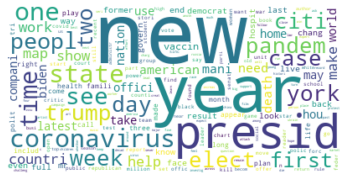

In [20]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#this visualization formatting code was shared with me by Leaha Nagy, a fellow Metis student.
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 500
# set width and height to higher quality, 3000 x 2000
word_cloud = WordCloud(collocations = False, background_color = 'white',width=3000, height=2000, max_words=100).generate(text)
#wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(df['porter'])
# set the word color to black
word_cloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(word_cloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
# save the image
plt.savefig('word_cloud_all.png')

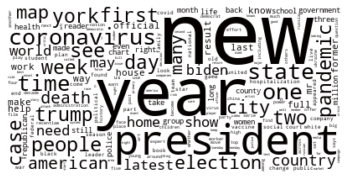

In [23]:
def wordcloud_func(text, **kwargs):
    word_cloud = WordCloud(collocations = False, background_color = 'white', color_func = black_color_func).generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    return(plt.show())
text = " ".join(word for word in df_snip.filtered)
wordcloud_func(text)
#word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


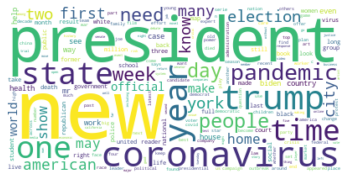

In [25]:
#now filtering by date range for new wordcloud
filtered_data = df_snip[(df_snip['pub_date'] > pd.Timestamp(2020,1,1)) & (df_snip['pub_date'] < pd.Timestamp(2020,12,1))]
text = " ".join(word for word in filtered_data.filtered)

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
#filtered_data = filtered_data[(filtered_data.section_name == 'U.S.')]
#selections = ['U.S.','Arts','World']
filtered_data = filtered_data[(filtered_data['section_name'].isin(sec))]
filtered_data.section_name.unique()

array(['Opinion', 'U.S.', 'Sports', 'Crosswords & Games', 'Corrections',
       'World', 'Today’s Paper', 'Briefing', 'Arts',
       'The Learning Network', 'Real Estate', 'Style', 'Books', 'Travel',
       'New York', 'Movies', 'Health', 'Business Day', 'Podcasts',
       'Theater', 'T Magazine', 'Technology', 'Magazine', 'Food',
       'Climate', 'Well', 'Science', 'Fashion & Style', 'Parenting',
       'At Home'], dtype=object)

In [27]:
text = " ".join(word for word in df_snip.filtered)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

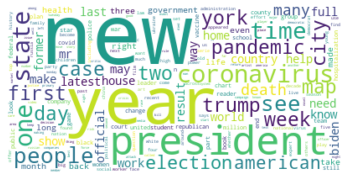

In [28]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Document Term Matrix (dtm)

This is a matrix that counts the number of times each word is used in a document. The dtm is then used with non-negative matrix factorization (nmf) for topic modeling. 

In [29]:
article_count = 5000
if len(filtered_data.index) > article_count:
    use_count = article_count
else:
    use_count = len(filtered_data.index)


In [30]:
use_count

5000

In [32]:
#create a smaller dataset for proof of concept
article_count = 5000
df_snip_trim = df_snip.sample(n=use_count)#, random_state = 42)

In [34]:
#create a list of the stemmed series, for use in the countvectorizer
corpus_snow = list(df_snip_trim.filtered)

In [35]:
#this code uses the first 100 characters from the resolution title as the index for the dataframe--this aids with interpretability
indx_label = [e[:100]+"..." for e in df_snip_trim.snippet]

In [36]:
#some math
923*.99

913.77

In [37]:
#countvectorizer creates the dtm. 
#with min_df = 10 I am excluding terms that occur in more than 10 documents (this is arbtrary),
#with max_df = .99, I am excluding terms that occur in more than 99% of the documents. This is conservative and could be more aggressive

#ngrams explored here include uni-gram, bi-gram, and tri-gram. I want to see if words used in proximity occur at great enough 
#frequency to be significant. 

#I'm also removing any stop words that made it through the earlier regex stop word removal

cv = CountVectorizer(stop_words = 'english', min_df = 6, max_df = .95, ngram_range=(1, 3))#min_df = 6, max_df = .99, 
#using the snowball stemmed data for the dtm
X_snow = cv.fit_transform(corpus_snow)
dtm_snow = pd.DataFrame(X_snow.toarray(), index=indx_label, columns=cv.get_feature_names_out())
dtm_snow

,ability,able,abortion,abortions,abuse,abused,academy,access,according,account,...,york city,york city region,york times,york times crossword,yorkers,young,younger,youtube,zero,zone
"The proceedings, billed as Dr. Anthony Fauci’s high noon, became a surreal pageant of dystopian gove...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A rise in starting salaries could help counter burnout but pandemic precautions might become a more ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"The man, who had a heated confrontation with the workers as he drove through a downtown intersection...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"The Republican senator, 88, is the former head of two high-profile Senate committees and will spare ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A group that sought to create Connecticut’s first experiment in collaborative living fell short. Som...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Steve Huffman, Reddit’s co-founder and chief executive, says new rule changes will help the company ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"This season, step out in glittering fabrics, striking silhouettes and whimsical textures made with c...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Corrections that appeared in print on Wednesday, Dec. 16, 2020....",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Readers respond to the situation in Australia....,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#take a look at features names and tune cv parameters if desired
cv.get_feature_names()

/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['ability',
 'able',
 'abortion',
 'abortions',
 'abuse',
 'abused',
 'academy',
 'access',
 'according',
 'account',
 'accusations',
 'accused',
 'accuses',
 'acknowledged',
 'act',
 'action',
 'actions',
 'activist',
 'activists',
 'activities',
 'actor',
 'actress',
 'adam',
 'adams',
 'adaptation',
 'add',
 'added',
 'address',
 'administration',
 'advance',
 'advanced',
 'advice',
 'advocates',
 'affect',
 'afghan',
 'afghanistan',
 'africa',
 'african',
 'aftermath',
 'age',
 'agencies',
 'agency',
 'agenda',
 'agent',
 'agents',
 'aggressive',
 'ago',
 'agreed',
 'agreement',
 'ahead',
 'aid',
 'aimed',
 'aims',
 'air',
 'alabama',
 'alaska',
 'album',
 'albums',
 'alcohol',
 'alex',
 'alive',
 'allegation',
 'allegations',
 'allow',
 'allowed',
 'allowing',
 'amazon',
 'ambitious',
 'amendment',
 'america',
 'american',
 'americans',
 'amid',
 'amy',
 'analysis',
 'andrew',
 'andrew cuomo',
 'angeles',
 'anger',
 'animals',
 'animated',
 'announced',
 'announcement',
 'answer',

## NMF

Here the words in the corpus will be clusterd into use groups. Then I will choose a lable or "topic" for each cluster. This is the topic modeling step.

In [39]:
#15 top Through trial and error, this seems like a good number for me. Beyond 15 topics, I see repetition. Below 15, some significant ones are omitted 

#A NEXT STEP! I would like to use nmf coherence score to optimize the number of topics. 

#'nndsvda': NNDSVD with zeros filled with the average of X (better when sparsity is not desired)

nmf = NMF(15, init = "nndsvda") 
nmf.fit(dtm_snow)

NMF(init='nndsvda', n_components=15)

In [40]:
#now create the topic-term-matrix, with three significant digits.
topic_term = nmf.components_.round(3)
topic_term.shape

(15, 2380)

In [41]:
#and turn it into a dataframe with topic cluster as rows, and terms as columns
topic_term_df = pd.DataFrame(topic_term, columns = cv.get_feature_names_out())
topic_term_df

,ability,able,abortion,abortions,abuse,abused,academy,access,according,account,...,york city,york city region,york times,york times crossword,yorkers,young,younger,youtube,zero,zone
0,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.004,0.000
1,0.003,0.000,0.050,0.009,0.011,0.001,0.022,0.000,0.052,0.000,...,0.000,0.000,0.000,0.000,0.119,0.011,0.015,0.007,0.000,0.000
2,0.000,0.005,0.000,0.002,0.011,0.002,0.000,0.031,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.006,0.005,0.000,0.003,0.011
3,0.000,0.009,0.001,0.006,0.000,0.000,0.000,0.001,0.000,0.000,...,0.000,0.000,0.000,0.000,0.011,0.002,0.000,0.003,0.000,0.000
4,0.004,0.004,0.009,0.001,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.003,0.023,0.000,0.022,0.005,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.000,0.096,0.000
6,0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.599,0.373,0.000,0.000,0.000,0.016,0.003,0.000,0.000,0.002
7,0.012,0.014,0.000,0.012,0.002,0.000,0.000,0.000,0.021,0.000,...,0.000,0.000,0.000,0.000,0.000,0.027,0.000,0.000,0.000,0.001
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.006,0.020,0.000,...,0.000,0.000,0.000,0.001,0.000,0.009,0.000,0.000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000,0.013,0.043,0.011,0.003,0.038,...,0.000,0.000,1.263,0.260,0.000,0.000,0.000,0.002,0.000,0.000


In [42]:
# Function to display the top n terms in each topic--this code from Metis

def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [43]:
output = display_topics(nmf, cv.get_feature_names_out(), 10)


Topic  1
cases, latest, deaths, coronavirus cases, hospitalizations, coronavirus, cases deaths, charts, charts maps, maps coronavirus cases

Topic  2
new, york, new york, jersey, new jersey, series, life, season, study, state

Topic  3
president, biden, president biden, house, president trump, white, white house, vice, vice president, american

Topic  4
know, need, day, need know, end, end day, know end, need know end, know end day, quotation day

Topic  5
results, maps, results maps, election, elections, primary, primary elections, texas, maps texas, results maps texas

Topic  6
pandemic, life, coronavirus pandemic, make, home, economic, work, amid, school, world

Topic  7
city, new york city, york city, york, new york, recent, mayor, sales, region, residential

Topic  8
year, old, year old, past, past year, articles, word, com, com past year, nytimes com

Topic  9
help, today, puzzle, feeling, stuck, today puzzle help, stuck today puzzle, puzzle help, stuck today, today puzzle

Topi

In [46]:
#now apply my own labels to the topic clusters, and show top 5 terms per topic
display_topics(nmf, cv.get_feature_names(), 5, [
    '1. COVID 19', 
    '2. New Jersey/New York Series', 
    '3. President of the US',
    '4. Recent NYT word use', 
    '5. Election maps', 
    '6. Pandemic Life',
    '7. NYC mayor',
    '8. The past year',
    '9. Puzzles',
    '10. The New York Times',
    '11. Geopolitics',
    '12. Corrections to print',
    '13. People',
    '14. Trump',
    '15. Coronavirus outbreak'
]);


Topic:  1. COVID 19
cases, latest, deaths, coronavirus cases, hospitalizations

Topic:  2. New Jersey/New York Series
new, york, new york, jersey, new jersey

Topic:  3. President of the US
president, biden, president biden, house, president trump

Topic:  4. Recent NYT word use
know, need, day, need know, end

Topic:  5. Election maps
results, maps, results maps, election, elections

Topic:  6. Pandemic Life
pandemic, life, coronavirus pandemic, make, home

Topic:  7. NYC mayor
city, new york city, york city, york, new york

Topic:  8. The past year
year, old, year old, past, past year

Topic:  9. Puzzles
help, today, puzzle, feeling, stuck

Topic:  10. The New York Times
york, new york, times, new york times, york times

Topic:  11. Geopolitics
states, united, united states, week, russia

Topic:  12. Corrections to print
appeared, corrections, print, appeared print, corrections appeared print

Topic:  13. People
people, world, officials, like, country

Topic:  14. Trump
trump, presi

In [48]:
#now create the document-topic matrix (earlier we had the nmf topic-term matrix)
doc_topic = nmf.transform(dtm_snow)
doc_topic.shape

(5000, 15)

In [50]:
#and turn it into a dataframe for further use and interpretability
#The higher the score, the more the topic label/category fits the document

doc_topic_df = pd.DataFrame(doc_topic.round(5), index = indx_label, columns = [
    '1. COVID 19', 
    '2. New Jersey/New York Series', 
    '3. President of the US',
    '4. Recent NYT word use', 
    '5. Election maps', 
    '6. Pandemic Life',
    '7. NYC mayor',
    '8. The past year',
    '9. Puzzles',
    '10. The New York Times',
    '11. Geopolitics',
    '12. Corrections to print',
    '13. People',
    '14. Trump',
    '15. Coronavirus outbreak' 
])
doc_topic_df

,1. COVID 19,2. New Jersey/New York Series,3. President of the US,4. Recent NYT word use,5. Election maps,6. Pandemic Life,7. NYC mayor,8. The past year,9. Puzzles,10. The New York Times,11. Geopolitics,12. Corrections to print,13. People,14. Trump,15. Coronavirus outbreak
"The proceedings, billed as Dr. Anthony Fauci’s high noon, became a surreal pageant of dystopian gove...",0.0,0.00232,0.00000,0.00044,0.00000,0.00000,0.00000,0.00000,0.00054,0.0000,0.00268,0.00000,0.04960,0.00000,0.00446
A rise in starting salaries could help counter burnout but pandemic precautions might become a more ...,0.0,0.00000,0.00000,0.00000,0.00000,0.16839,0.00000,0.00000,0.11832,0.0000,0.00000,0.00000,0.00000,0.00000,0.00392
"The man, who had a heated confrontation with the workers as he drove through a downtown intersection...",0.0,0.00274,0.00000,0.00000,0.00000,0.00000,0.00000,0.02167,0.00242,0.0012,0.00370,0.00000,0.05337,0.00000,0.00186
"The Republican senator, 88, is the former head of two high-profile Senate committees and will spare ...",0.0,0.00289,0.00873,0.00088,0.05121,0.00500,0.00000,0.00000,0.00000,0.0000,0.00000,0.00219,0.03053,0.03371,0.01193
A group that sought to create Connecticut’s first experiment in collaborative living fell short. Som...,0.0,0.00750,0.00166,0.00000,0.00217,0.01916,0.00000,0.01388,0.00364,0.0000,0.00000,0.00000,0.03412,0.00003,0.00025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Steve Huffman, Reddit’s co-founder and chief executive, says new rule changes will help the company ...",0.0,0.17226,0.00195,0.00000,0.00000,0.00976,0.00000,0.00021,0.12846,0.0000,0.00000,0.00000,0.01674,0.00365,0.01752
"This season, step out in glittering fabrics, striking silhouettes and whimsical textures made with c...",0.0,0.00521,0.00051,0.00187,0.00000,0.00273,0.00125,0.00071,0.00014,0.0000,0.00034,0.00000,0.00525,0.00037,0.00145
"Corrections that appeared in print on Wednesday, Dec. 16, 2020....",0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.61726,0.00000,0.00000,0.00000
Readers respond to the situation in Australia....,0.0,0.00000,0.00206,0.00105,0.00000,0.00056,0.00000,0.00000,0.00019,0.0014,0.00456,0.00069,0.01097,0.00000,0.00000


In [51]:
#this code from stackexchange

# find the column name of maximum values in every row
maxValueIndex = doc_topic_df.idxmax(axis = 1)
 
maxValueIndex_df = pd.DataFrame(maxValueIndex, columns=['topic'])
maxValueIndex_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, The proceedings, billed as Dr. Anthony Fauci’s high noon, became a surreal pageant of dystopian gove... to A record number of abstentions, and a strictly binary choice for voters — many of whom said they wer...
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   5000 non-null   object
dtypes: object(1)
memory usage: 78.1+ KB


In [52]:
#now we have a dataframe with (first 100 characters of ) resolution titles and the best topic label for that resolution
maxValueIndex_df.head(50)

,topic
"The proceedings, billed as Dr. Anthony Fauci’s high noon, became a surreal pageant of dystopian gove...",13. People
A rise in starting salaries could help counter burnout but pandemic precautions might become a more ...,6. Pandemic Life
"The man, who had a heated confrontation with the workers as he drove through a downtown intersection...",13. People
"The Republican senator, 88, is the former head of two high-profile Senate committees and will spare ...",5. Election maps
A group that sought to create Connecticut’s first experiment in collaborative living fell short. Som...,13. People
"At The New York Times presses in Queens, making the paper Tuesday night felt pretty normal....",10. The New York Times
"Philip Post is the designer and founder of Dertbag, a street wear brand with roots in Connecticut....",13. People
Like Brad Pitt and Jake Gyllenhaal? How about Wednesday Addams? Catch them on the streaming service ...,13. People
"Tobacco and marijuana products damage lungs, where the virus does its harm. Health officials are urg...",13. People
"New novels — by turns salty, sweeping and sweet — will transport you to 1930s Italy, 19th-century En...",2. New Jersey/New York Series


In [39]:
#This code I pulled from my ESG NLP project and needs to be adapted for this project

#Prepare to merge the new topics lable df with the original df, for further exploration and analysis (eg changes over time!)
left = df.drop(['status', 'organization', 'filtered','title', 'filed_by',
       'preprocessed', 'lancaster', 'snowball', 'tokenized', 'whereas'
       ], axis = 1)
left['indx_label'] = [e[:100]+"..." for e in df.title]
left = left.set_index('indx_label')
right = maxValueIndex_df

In [41]:
#merge! this code needs correcting. 
result = pd.merge(left, right, left_index= True,right_index = True)
result.drop_duplicates()

,year,porter,topic
Adopt GHG reduction targets...,2022,air product address risk opportun present clim...,1. Climate emissions targets
Adopt GHG reduction targets...,2022,increas rate number climat relat disast affect...,1. Climate emissions targets
Adopt GHG reduction targets...,2022,increas rate number climat relat disast affect...,1. Climate emissions targets
Adopt GHG reduction targets...,2022,intergovernment panel climat chang evalu goal ...,1. Climate emissions targets
Adopt GHG reduction targets...,2022,support set publish target consist goal pari c...,1. Climate emissions targets
...,...,...,...
Uncategorized...,2019,santand consum usa hold inc compani board dire...,5. ESG management and corporate policies
Uncategorized...,2019,santand consum usa hold inc compani board dire...,4. Campaign Contributions
Uncategorized...,2019,recommend tesla inc compani establish public p...,1. Climate emissions targets
Uncategorized...,2019,recommend tesla inc compani establish public p...,5. ESG management and corporate policies


## Word Count Plot

A nifty visualization

In [55]:
snow_list = [' '.join(df_snip['snowball'])]
snow_str = ' '
for x in snow_list:
    snow_str += ' ' + x

In [57]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

counts = word_count(snow_str)

In [67]:
import operator
sorted_d = dict( sorted(counts.items(), key=operator.itemgetter(1),reverse=True))
#print('Dictionary in descending order by value : ',sorted_d)
dc = {k: v for k, v in sorted_d.items() if v > 2500}
print(dc)

{'new': 15639, 'year': 8963, 'presid': 8721, 'coronavirus': 6869, 'one': 6753, 'state': 6588, 'time': 6235, 'see': 5593, 'peopl': 5351, 'pandem': 5018, 'citi': 4960, 'trump': 4921, 'day': 4902, 'york': 4757, 'elect': 4726, 'two': 4706, 'week': 4694, 'case': 4652, 'first': 4580, 'countri': 4453, 'make': 4332, 'map': 4293, 'help': 4193, 'work': 4155, 'show': 4087, 'american': 4006, 'would': 3932, 'mani': 3882, 'could': 3874, 'need': 3859, 'like': 3855, 'death': 3804, 'world': 3490, 'home': 3417, 'latest': 3375, 'also': 3358, 'hous': 3348, 'compani': 3325, 'offici': 3285, 'may': 3261, 'biden': 3244, 'nation': 3239, 'use': 3229, 'get': 3164, 'take': 3146, 'vaccin': 3058, 'chang': 2934, 'hospit': 2924, 'result': 2875, 'know': 2861, 'former': 2852, 'back': 2815, 'democrat': 2796, 'govern': 2746, 'look': 2739, 'last': 2723, 'way': 2692, 'full': 2619, 'mr': 2602, 'even': 2578, 'end': 2525, 'face': 2516}


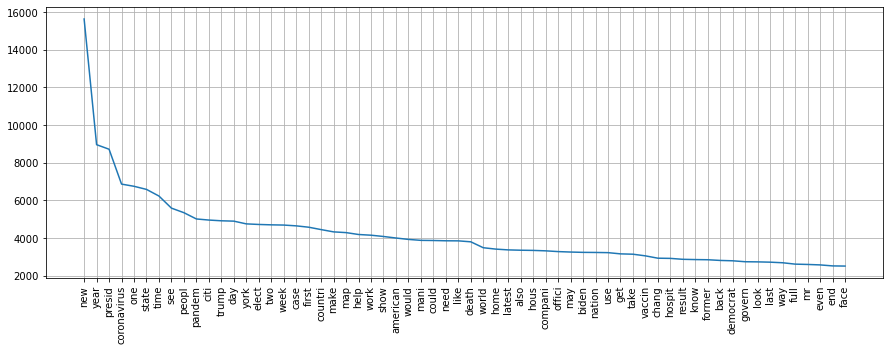

In [68]:
#now plot, line plot!

myList = dc.items()
#myList = sorted(myList) 
x, y = zip(*myList) 

plt.figure(figsize=(15, 5))
plt.plot(x, y)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.grid()
plt.savefig('wordcount.png')
plt.show();

In [ ]:
#can compare portland to snowball stemmer, repeat the above steps to compare! Have fun!
X_snow = cv.fit_transform(corpus_snow)
dtm_snow = pd.DataFrame(X_snow.toarray(), index=indx_label, columns=cv.get_feature_names())
#dtm.to_csv('dtm_porter.csv')
dtm_snow

In [ ]:
#can compare portland to Lancaster stemmer, repeat the above steps to compare! Have fun!
X_lanc = cv.fit_transform(corpus_lanc)
dtm_lanc = pd.DataFrame(X_lanc.toarray(), index=indx_label, columns=cv.get_feature_names())
#dtm.to_csv('dtm_porter.csv')
dtm_lanc

## Sentiment Score

Assigning positive negative or nuetral scores to the documents

In [69]:
corpus_list = list(df_snip.snowball)
corpus_list[0] #check to see the corpus is formatted correctly (do not apply sent score to each letter!)

'gunman shot two parishion west freeway church christ come earlier look food money church leader'

In [70]:
#run the sentiment analyzer
analyzer = SentimentIntensityAnalyzer() 
score = analyzer.polarity_scores(corpus_list)
print(score) #earlier results, for comparison through iterations {'neg': 0.074, 'neu': 0.795, 'pos': 0.131, 'compound': 1.0} on June 17 all 923 docs
# later results on list(df.porter) = {'neg': 0.076, 'neu': 0.794, 'pos': 0.131, 'compound': 1.0}


KeyboardInterrupt: 

In [63]:
#update this code to work with this project (I pulled this from my ESG NLP project)

#put scores into df for interpretation. Here, the scores are based on 'whereas'. Should be based on stemmed columns!
#RETURN AND FIX THIS!
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['whereas']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['whereas']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['whereas']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['whereas']]
df

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,tokenized,porter,lancaster,snowball,compound,neg,neu,pos
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",In our Company s Sustainability Report C...,Company Sustainability Report CEO Mike Roman s...,"[Company, Sustainability, Report, CEO, Mike, R...",compani sustain report ceo mike roman state co...,company sustain report ceo mik rom stat commit...,compani sustain report ceo mike roman state co...,0.9697,0.107,0.746,0.147
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,We believe in full disclosure of Abbott Labora...,believe disclosure Abbott Laboratories Abbott ...,"[believe, disclosure, Abbott, Laboratories, Ab...",believ disclosur abbott laboratori abbott dire...,believ disclos abbot lab abbot direct indirect...,believ disclosur abbott laboratori abbott dire...,0.5205,0.115,0.780,0.105
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,The political expenditures of AbbVie Inc appe...,political expenditures AbbVie Inc appear misal...,"[political, expenditures, AbbVie, Inc, appear,...",polit expenditur abbvi inc appear misalign pub...,polit expendit abbvy int appear misalign publ ...,polit expenditur abbvi inc appear misalign pub...,0.9956,0.031,0.801,0.168
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products ad...,Air Products address risks opportunities prese...,"[Air, Products, address, risks, opportunities,...",air product address risk opportun present clim...,air produc address risk opportun pres clim cha...,air product address risk opportun present clim...,0.9545,0.013,0.830,0.156
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,The increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...",increas rate number climat relat disast affect...,increas rat numb clim rel disast affect socy c...,increas rate number climat relat disast affect...,0.2960,0.054,0.883,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,Vote,Report on supply chain deforestation impacts,"Mondelez International, Inc.",SumOfUS,2019,Resolved:\nShareholders request that Mondelēz ...,Resolved Shareholders request that Mondel z I...,Mondel z International Inc Mondelez report ann...,"[Mondel, z, International, Inc, Mondelez, repo...",mondel z intern inc mondelez report annual ini...,mondel z intern int mondelez report an init ma...,mondel z intern inc mondelez report annual ini...,0.2263,0.084,0.817,0.099
938,Vote,Report on pay disparity,"Mondelez International, Inc.",AFL-CIO,2019,Resolved: Shareholders of Mondelez Internation...,Resolved Shareholders of Mondelez Internation...,Mondelez International Inc Company Compensatio...,"[Mondelez, International, Inc, Company, Compen...",mondelez intern inc compani compens committe b...,mondelez intern int company compens commit boa...,mondelez intern inc compani compens committe b...,-0.3626,0.071,0.885,0.044
939,Vote,Report on lobbying,Morgan Stanley,"Boston Common Asset Management, LLC",2019,we believe in full disclosure of Morgan Stanle...,we believe in full disclosure of Morgan Stanle...,believe disclosure Morgan Stanley direct indir...,"[believe, disclosure, Morgan, Stanley, direct,...",believ disclosur morgan stanley direct indirec...,believ disclos morg stanley direct indirect lo...,believ disclosur morgan stanley direct indirec...,-0.0275,0.089,0.851,0.060
940,Vote,Nominate human rights expert to board,"Motorol

In [66]:
df.to_csv('sent_score_df.csv')

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

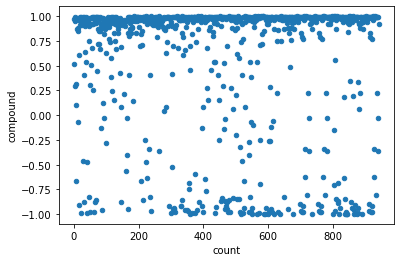

In [64]:
df['count'] = df.index+1
plt = df.plot(x ='count', y='compound', kind = 'scatter')
plt.savefig('sentiment.png')